# Trabalho de 'Data Mining' do curso 'BI MASTER 2020-2'
## Estudo de caso: Previsão de vendas de produtos específico em uma empresa varejista
**Grupo** (ordem alfabética):
- Alex Marques Campos
- Fernanda Viviani de Paula
- Gustavo Dutra Martins

In [1]:
import datetime
import math
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# chamamos o método 'set' do seaborn para ajustar os valores padrão de exibição dos gráficos
sns.set_theme()
sns.set()

In [3]:
# variáveis globais "constantes" apontando para os conjuntos de dados
PATH_DATASET="base"
PATH_DATASET_PRODUTO=os.path.join(PATH_DATASET,"BaseProduto.csv")
PATH_DATASET_VENDA=os.path.join(PATH_DATASET,"BaseVenda.csv")
PATH_DATASET_LOJA=os.path.join(PATH_DATASET,"BaseLoja.csv")

PATH_DATASET_VENDA_PREPARADO=os.path.join(PATH_DATASET,"venda_preparado.csv")

**Atenção**: Se não tiver o conjunto de dados original, pule os trechos abaixo e execute o código a partir da célula de [carga dos dados processados](#Carga-dos-dados-processados).

## Carga dos conjuntos de dados: 'vendas', 'lojas' e 'produtos'

In [4]:
%time df_venda = pd.read_csv(PATH_DATASET_VENDA, delimiter='|', encoding='cp1252')

Wall time: 1min 33s


In [5]:
%time df_loja = pd.read_csv(PATH_DATASET_LOJA, delimiter='|', encoding='cp1252')

Wall time: 78.8 ms


In [6]:
%time df_produto = pd.read_csv(PATH_DATASET_PRODUTO, delimiter='|', encoding='cp1252', low_memory=False)

Wall time: 4.86 s


In [7]:
df_produto.head()

,ARTIGO,ARTIGO_PAI,DESCRICAO,REFERENCIA,COR,TAMANHO,FORNECEDOR,NOME_FANTASIA_FORN,SECAO,GRUPO,...,ULTIMA_COMPRA,CD_FORNECEDOR,VITRINE_N1,VITRINE_N2,VITRINE_N3,SOLA,SALTO,FORRO,ESSOLA,PALMILHA
0,10000/00-0,10000/00-0,FIREZZI IN09 74008/7/9,0,48401-PRETO,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000/01-7,10000/00-0,FIREZZI IN09 74008/7/9,74008,CAM PRETO,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000/02-4,10000/00-0,FIREZZI IN09 74008/7/9,74009,CAM CASTOR.,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000/03-1,10000/00-0,FIREZZI IN09 74008/7/9,74007,CAM PRETO,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000/04-8,10000/00-0,FIREZZI IN09 74008/7/9,74009,CAM PRETO,99,***PROMOCAO,PROMOCAO,CALCADOS,FEMININO,...,2009-02-16 00:00:00.0000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Filtramos o conjunto de dados para obter apenas calçados femininos vendidos no Rio de Janeiro


In [8]:
df_venda_preparado = df_venda[(df_venda.SECAO == 'CALCADOS') & 
                              (df_venda.GRUPO == 'FEMININO') &
                              (df_venda.CIDADE == 'RIO DE JANEIRO')]

In [9]:
print(df_venda.shape)
print(df_venda_preparado.shape)

(19559118, 15)
(2215699, 15)


In [10]:
perc_dados_selec_orig = (df_venda_preparado.shape[0] / df_venda.shape[0]) * 100
print(f'Percentual de dados selecionados: {perc_dados_selec_orig:.2f} %')

Percentual de dados selecionados: 11.33 %


##### Removemos colunas desnecessárias ao processamento

In [11]:
df_venda_preparado = df_venda_preparado.drop(['NumeroBoleta', 
                                              'Loja', 
                                              'UF', 
                                              'CIDADE',
                                              'BAIRRO', 
                                              'Produto_Codigo', 
                                              'SECAO', 
                                              'GRUPO', 
                                              'CATEGORIA', 
                                              'COR', 
                                              'TAMANHO', 
                                              'PrecoVenda', 
                                              'PrecoTransacao'], axis=1)

In [12]:
# verificamos se existem valores nulos nos dados
df_venda_preparado.isna().sum()

CriacaoReferencia    0
Quantidade           0
dtype: int64

In [13]:
# número de registros antes da aglutinação
qtd_dados_venda_preparado_antes = df_venda_preparado.shape[0]

# aglutinamos (somando) os dados que ocorrem na mesma CriacaoReferencia
df_venda_preparado = df_venda_preparado.groupby(by=['CriacaoReferencia'], as_index=False)['Quantidade'].sum()

# número de registros depois da aglutinação
qtd_dados_venda_preparado_depois = df_venda_preparado.shape[0]

In [14]:
df_venda_preparado.shape

(750, 2)

In [15]:
perc_reducao_dados_aglutinados = (1 - (qtd_dados_venda_preparado_depois / qtd_dados_venda_preparado_antes)) * 100
print(f'Percentual de redução do número de registros via aglutinação: {perc_reducao_dados_aglutinados:.2f} %')

Percentual de redução do número de registros via aglutinação: 99.97 %


In [16]:
# formatos padronizados para as datas
fmt_dt_iso='%Y-%m-%d'
fmt_dt_ano_mes='%Y-%m'
fmt_dt_ano_mes_semana='%Y-%m-%W'

In [17]:
# funções auxiliares para calcular as janelas de tempo
f_data_menos_uma_semana   = lambda d: d + relativedelta(weeks=-1)
f_data_menos_duas_semanas = lambda d: d + relativedelta(weeks=-2)
f_data_menos_um_ano       = lambda d: d + relativedelta(years=-1)

def formatar_data(df, coluna, formato):
    """Aplica um formato de data em uma coluna de um dataframe e a retorna."""
    return df[coluna].dt.strftime(formato)

def aplicar_funcoes(df, colunas_e_funcoes):
    """Percorre as tuplas de 'colunas_e_funcoes' e, para cada dicionario nela contidos, faz:
    - aplica a 'funcao' na coluna 'col_org', gravando o resultado na coluna 'col_dst' do dataframe 'df'
    """
    for e in colunas_e_funcoes:
        col_dst = e['col_dst']
        col_org = e['col_org']
        f_offset_data = e['funcao']
                
        # aplica a funcao 'f_offset_data' na coluna 'col_org' e 
        # salva o resultado na coluna 'col_dst'
        df[col_dst] = df[col_org].map(f_offset_data)
    
def aplicar_formatos_data(df, colunas_e_formatos):
    """Percorre as tuplas de 'colunas_e_formatos' e, para cada dicionario nela contidos, faz:
    - aplica o 'fmt_data' na coluna 'col_org', gravando o resultado na coluna 'col_dst' do dataframe 'df'
    """
    for e in colunas_e_formatos:
        col_dst = e['col_dst']
        col_org = e['col_org']
        fmt_data = e['fmt_data']
        
        # aplica o formato de data 'fmt_data' na coluna 'col_org' e 
        # salva o resultado na coluna 'col_dst'
        df[col_dst] = formatar_data(df, col_org, fmt_data)

In [18]:
# criamos uma coluna temporária de data da venda no padrão ISO
%time df_venda_preparado['DataVenda'] = pd.to_datetime(df_venda_preparado['CriacaoReferencia'],format=fmt_dt_iso)

Wall time: 5.98 ms


In [19]:
# criamos uma coluna de ano-mês para facilitar as aglutinações dos dados
%time df_venda_preparado['AnoMes'] =  formatar_data(df_venda_preparado, 'DataVenda', fmt_dt_ano_mes)

Wall time: 11 ms


In [20]:
# criamos colunas temporárias no dataframe para armazenar as datas de interesse
# essas colunas serão formatadas na sequência

# col_dst recebe funcao aplicada em col_org, na ordem das tuplas
colunas_e_offsets_de_tempo = (
    {'col_dst':'Data1SemanaAnterior',    'col_org': 'DataVenda',       'funcao': f_data_menos_uma_semana},
    {'col_dst':'Data2SemanaAnterior',    'col_org': 'DataVenda',       'funcao': f_data_menos_duas_semanas},
    {'col_dst':'DataAnoAnterior',        'col_org': 'DataVenda',       'funcao': f_data_menos_um_ano},
    {'col_dst':'DataAnoAnterior1Semana', 'col_org': 'DataAnoAnterior', 'funcao': f_data_menos_uma_semana},
    {'col_dst':'DataAnoAnterior2Semana', 'col_org': 'DataAnoAnterior', 'funcao': f_data_menos_duas_semanas}
)

# aplicamos as funções, medindo o tempo
%time aplicar_funcoes(df_venda_preparado, colunas_e_offsets_de_tempo)

Wall time: 187 ms


In [21]:
df_venda_preparado.shape

(750, 9)

In [22]:
# criamos colunas de datas específicas (formatadas) no dataframe para auxiliar a geração das janelas de
# tempo para o processamento dos algoritmos de regressão

# col_dst recebe formato de data aplicado em col_org, na ordem das tuplas
colunas_e_formatos = (
    {'col_dst':'AnoMesSemana',                   'col_org': 'DataVenda',              'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemana1SemanaAnterior',    'col_org': 'Data1SemanaAnterior',    'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemana2SemanaAnterior',    'col_org': 'Data2SemanaAnterior',    'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemanaAnoAnterior',        'col_org': 'DataAnoAnterior',        'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemanaAnoAnterior1Semana', 'col_org': 'DataAnoAnterior1Semana', 'fmt_data': fmt_dt_ano_mes_semana},
    {'col_dst':'AnoMesSemanaAnoAnterior2Semana', 'col_org': 'DataAnoAnterior2Semana', 'fmt_data': fmt_dt_ano_mes_semana}
)

# aplicamos os formatos, medindo o tempo
%time aplicar_formatos_data(df_venda_preparado, colunas_e_formatos)

Wall time: 72.8 ms


In [23]:
df_venda_preparado.shape

(750, 15)

In [24]:
# removemos, do dataframe, as colunas que não são mais necessárias para processamento posterior
colunas_a_remover = ['CriacaoReferencia',
                     'DataVenda',
                     'Data1SemanaAnterior',
                     'Data2SemanaAnterior',
                     'DataAnoAnterior',
                     'DataAnoAnterior1Semana',
                     'DataAnoAnterior2Semana']

%time df_venda_preparado.drop(colunas_a_remover, axis=1, inplace=True)

Wall time: 2.99 ms


In [25]:
df_venda_preparado.shape

(750, 8)

In [26]:
# salvamos uma cópia dos dados preparados para a análise
# visando permitir o trabalho sem o conjunto de dados
# original.
df_venda_preparado.to_csv(PATH_DATASET_VENDA_PREPARADO)

##### Carga dos dados processados

In [27]:
# código para carregar o CSV com os dados pré-processados, se existir
# (para permitir a análise sem o conjunto de dados original inteiro)
if os.path.exists(PATH_DATASET_VENDA_PREPARADO) and os.path.isfile(PATH_DATASET_VENDA_PREPARADO):
    df_venda_preparado = pd.read_csv(PATH_DATASET_VENDA_PREPARADO)

---

### Análise Estatística

#### Grafico da série temporal e da Autocorrelação - Mensal

In [26]:
df_venda_agrupado_mes = df_venda_preparado.groupby(by=['AnoMes'], as_index=False)['Quantidade'].sum()
df_venda_agrupado_mes = df_venda_agrupado_mes.sort_values(['AnoMes'])

C:\Users\mrale\AppData\Roaming\Python\Python38\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


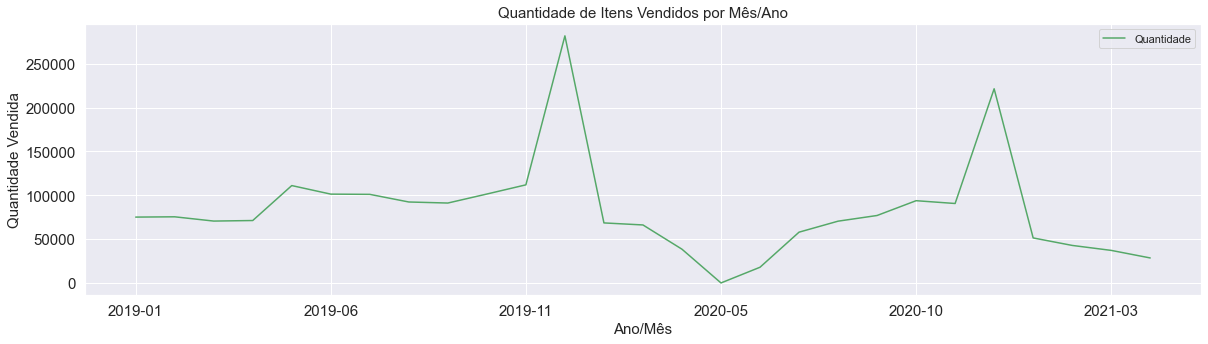

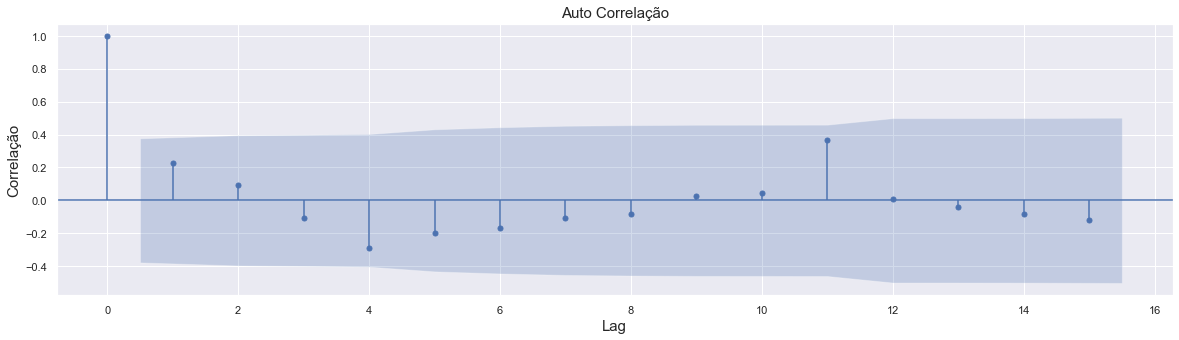

In [27]:
green = sns.color_palette("deep",8)[2]
blue = sns.color_palette("deep",8)[0]

fig, ax = plt.subplots(figsize=(20,5))
df_venda_agrupado_mes.plot(x="AnoMes",y="Quantidade",color="g", fontsize=15, ax=ax)
plt.xlabel("Ano/Mês",fontsize=15)
plt.title("Quantidade de Itens Vendidos por Mês/Ano", fontsize=15)
plt.ylabel("Quantidade Vendida", fontsize=15)
plt.show()


fig, ax = plt.subplots(figsize=(20,5))
plot_acf(df_venda_agrupado_mes.Quantidade, ax=ax)
plt.title("Auto Correlação", fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.ylabel("Correlação", fontsize=15)
plt.show()

#### Grafico da série temporal e da Autocorrelação - Semanal

In [28]:
df_venda_agrupado_semana = df_venda_preparado.groupby(by=['AnoMesSemana'], as_index=False)['Quantidade'].sum()

C:\Users\mrale\AppData\Roaming\Python\Python38\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


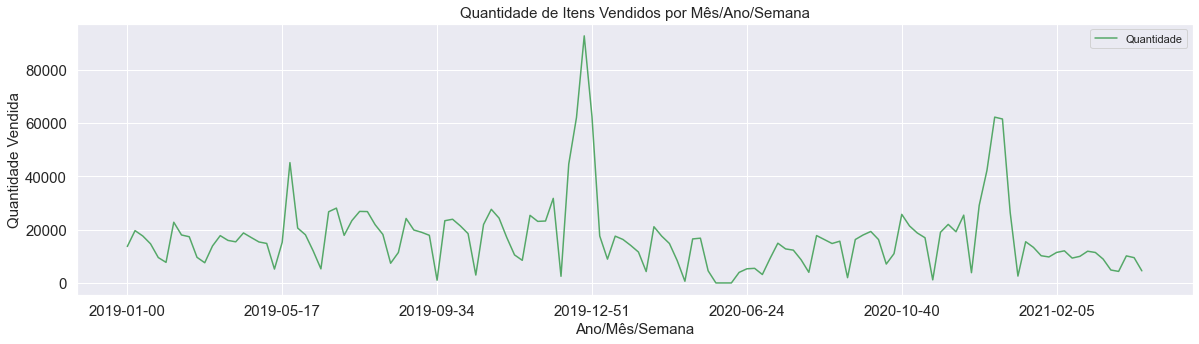

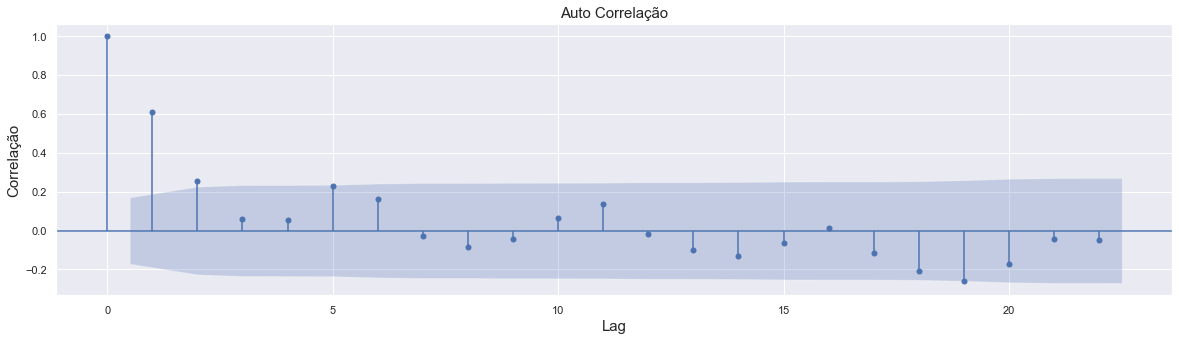

In [29]:
green = sns.color_palette("deep",8)[2]
blue = sns.color_palette("deep",8)[0]

fig, ax = plt.subplots(figsize=(20,5))
df_venda_agrupado_semana.plot(x="AnoMesSemana",y="Quantidade",color="g", fontsize=15, ax=ax)
plt.xlabel("Ano/Mês/Semana",fontsize=15)
plt.title("Quantidade de Itens Vendidos por Mês/Ano/Semana", fontsize=15)
plt.ylabel("Quantidade Vendida", fontsize=15)
plt.show()


fig, ax = plt.subplots(figsize=(20,5))
plot_acf(df_venda_agrupado_semana.Quantidade, ax=ax)
plt.title("Auto Correlação", fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.ylabel("Correlação", fontsize=15)
plt.show()

### Previsões Estatísticas

#### Média Móvel

In [30]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    

#### Média Móvel com janelas para agrupamento mês

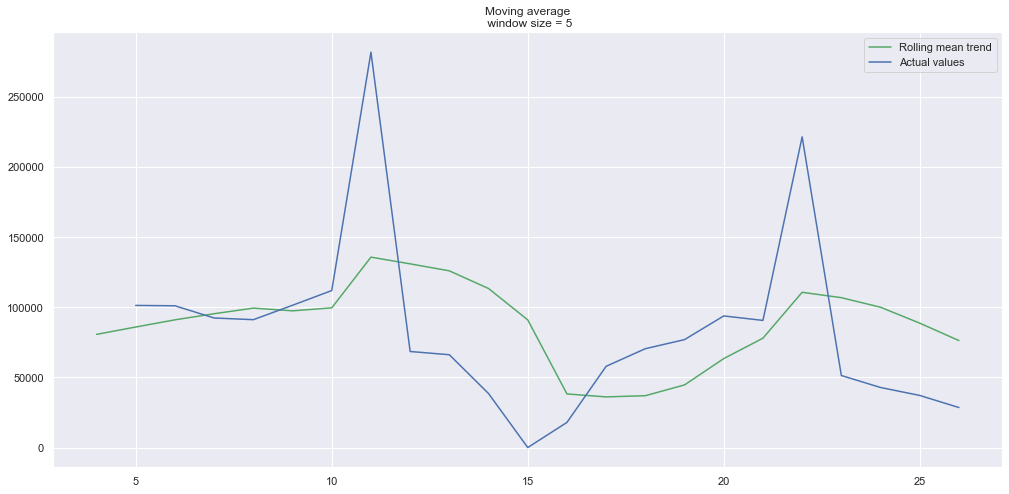

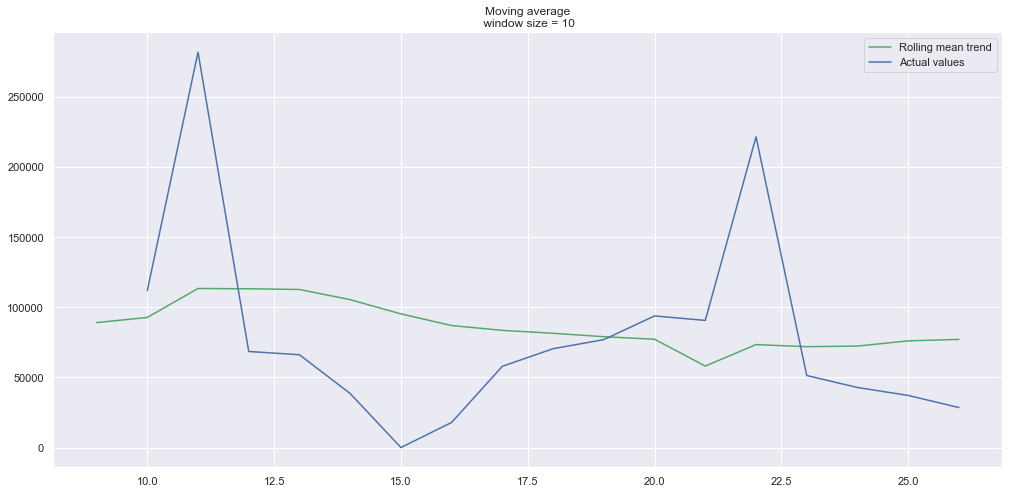

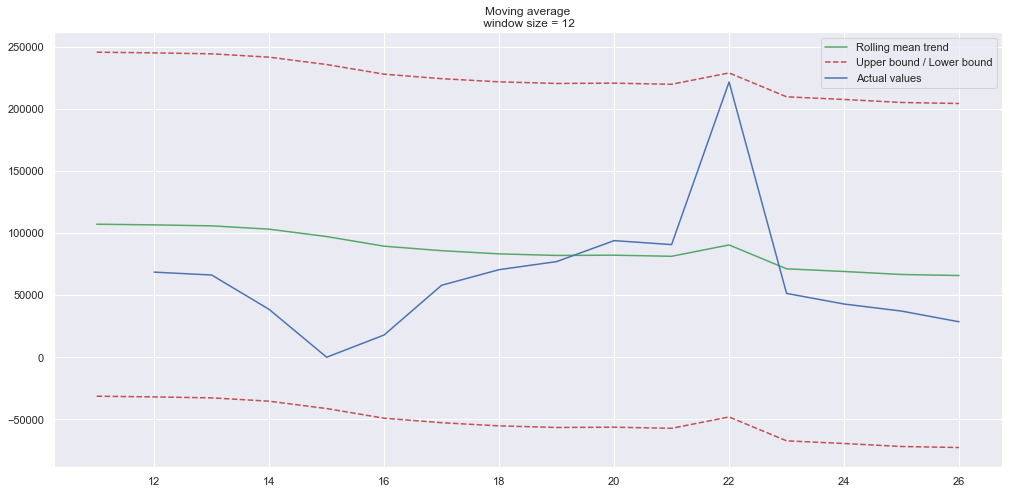

In [31]:
plot_moving_average(df_venda_agrupado_mes.Quantidade, 5)
plot_moving_average(df_venda_agrupado_mes.Quantidade, 10)
plot_moving_average(df_venda_agrupado_mes.Quantidade, 12, plot_intervals=True)

#### Média Móvel com janelas para agrupamento Semanal

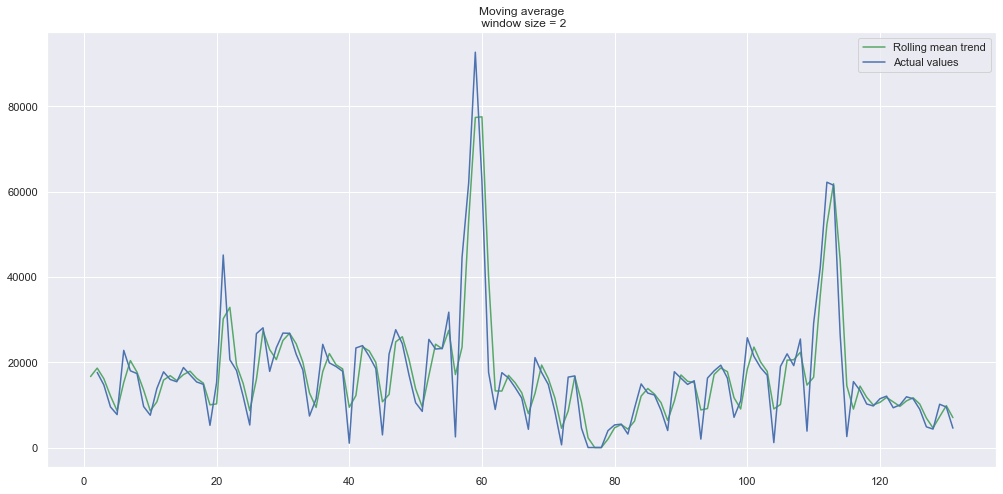

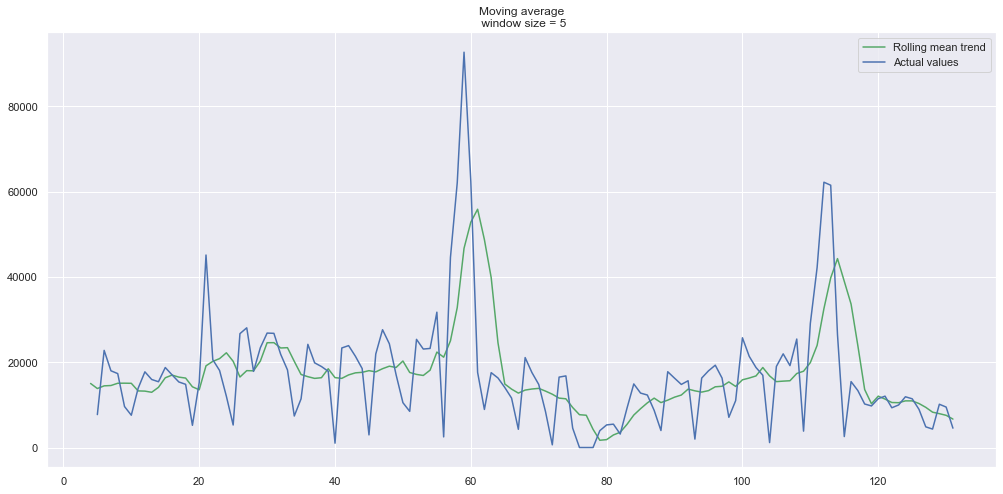

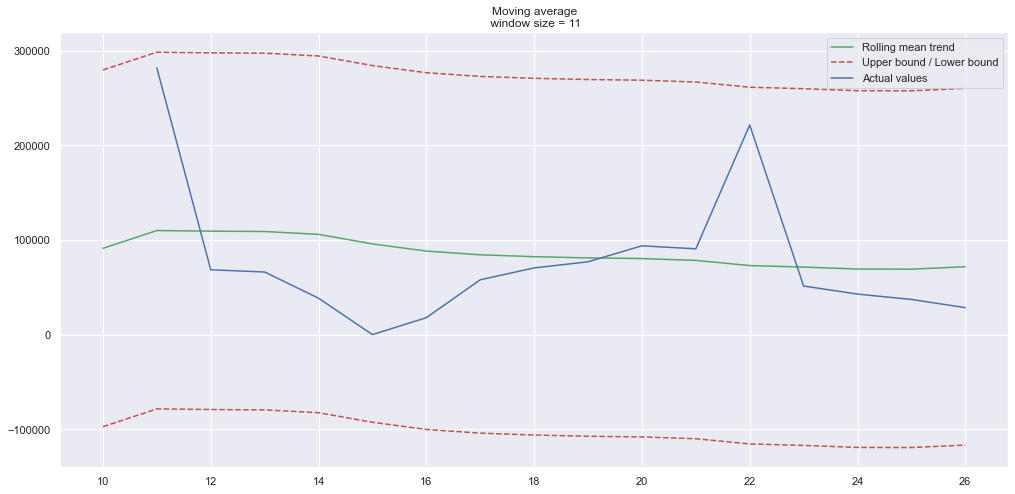

In [32]:
plot_moving_average(df_venda_agrupado_semana.Quantidade, 2)
plot_moving_average(df_venda_agrupado_semana.Quantidade, 5)
plot_moving_average(df_venda_agrupado_mes.Quantidade, 11, plot_intervals=True)

### Amortecimento Exponencial

In [33]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);



#### Mensal

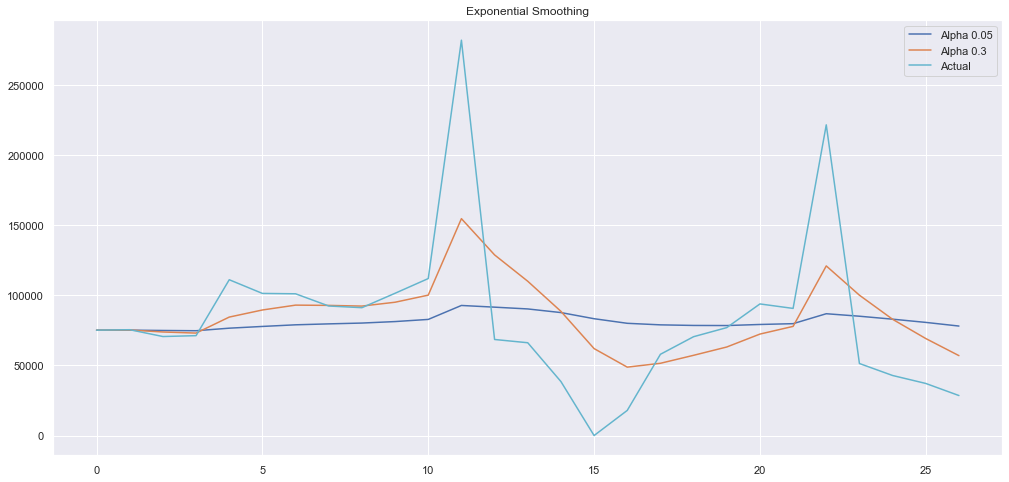

In [34]:
plot_exponential_smoothing(df_venda_agrupado_mes.Quantidade, [0.05, 0.3])

#### Semanal

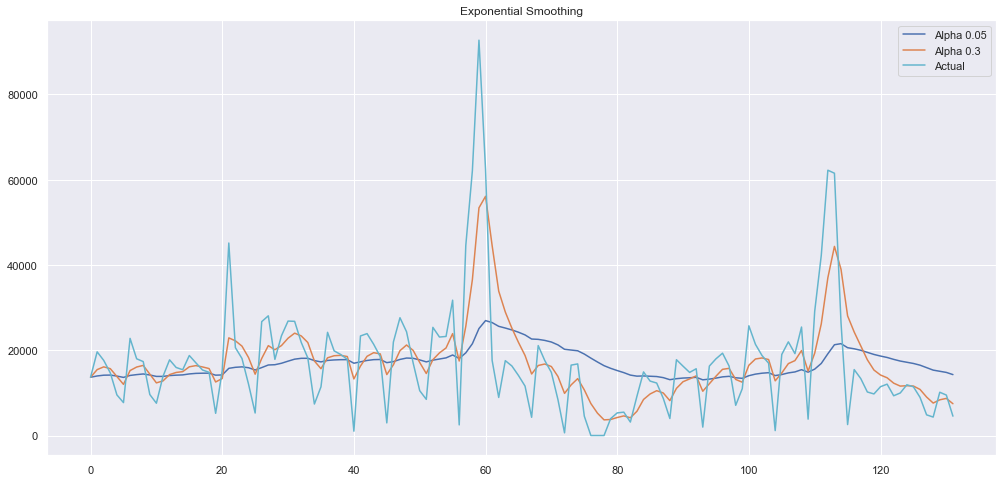

In [35]:
plot_exponential_smoothing(df_venda_agrupado_semana.Quantidade, [0.05, 0.3])

### ARIMA

MSE error: 129938428.28516339


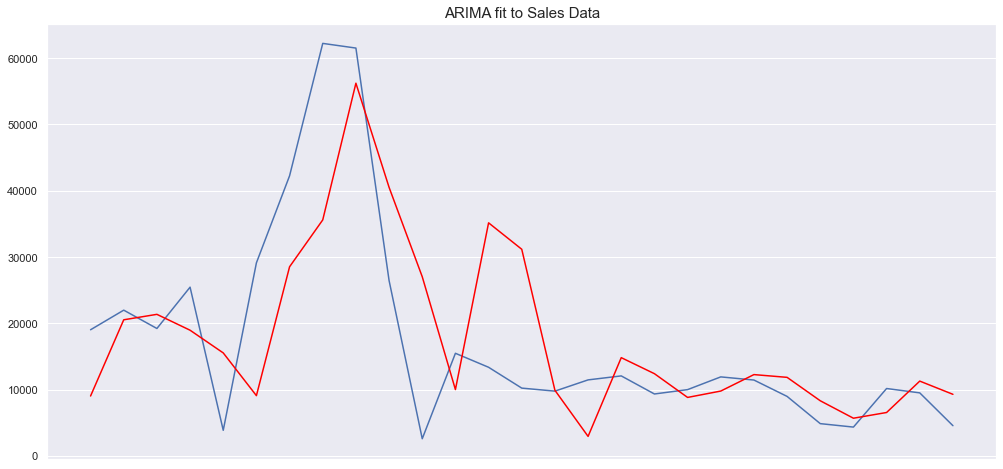

In [36]:
X = df_venda_agrupado_semana["Quantidade"].values

split = int(0.8*len(X))
train, test = X[0:split], X[split:]

history = [x for x in train]
predictions = []
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
    
	obs = test[t]
	history.append(obs)
mse = mean_squared_error(test, predictions)

print(f"MSE error: {mse}")

plt.figure(figsize=(17,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA fit to Sales Data",fontsize=15)
plt.xticks([])
plt.show()

## Previsões Machine Learning 

#### Todas as vendas realizadas agrupadas por semana

In [37]:
df_venda_historico_agrupado = df_venda_preparado.groupby(by=['AnoMesSemana'], as_index=False)['Quantidade'].sum()

#### Métricas de Erro

In [38]:
def calcula_metricas_erro(y_pred,y_test, number_features):
    rmse = math.sqrt(mean_squared_error(y_pred,y_test))
    print('RMSE: ', rmse)
    
    mse = mean_squared_error(y_pred,y_test)
    print('MSE: ',mse)    
    
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print('MAPE: ',mape, '%')
    
    r2 = r2_score(y_pred,y_test)
    print('R2 Score: ', r2)
    
    if (number_features is not None and number_features > 0): 
        number_samples = len(y_pred)
        adj_r2_score = 1-(1-r2)*(number_samples-1)/(number_samples-number_features-1)
        print('R2 Ajustado: ', adj_r2_score)
    

In [39]:
def mostra_grafico_previsao(y_pred, y_test):
    plt.plot(y_pred, label='previsto', marker='o')
    plt.plot(y_test, label='real', marker='+')
    plt.ylabel("Venda")
    plt.title("Previsão x Vendas")
    plt.legend()
    plt.show()

#### Montagem dos diferentes datasets para treino 

##### Dados da série histórica com a janela informada

In [40]:
def monta_dataset_por_janela(dataset=None, window=12):
    dataSize = len(dataset)
    X = []
    y = []
    for i in range(window, dataSize):
        X.append(dataset.iloc[i-window:i, 1])
        y.append(dataset.iloc[i, 1])
    X, y = np.array(X), np.array(y)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return x_train, x_test, y_train, y_test
    

##### Penúltima e antepenúltima semana/ mesma semana do ano anterior / penúltima e antepenúltima semana do ano anterior.

In [41]:
def monta_dataset_ano_anterior(dataset):
    df_venda_ml = dataset[dataset.AnoMesSemana >= '2020-01-02'].sort_values(['AnoMesSemana'])
    df_venda_agrupado_ml = df_venda_ml.groupby('AnoMesSemana', as_index=False).agg({
        'Quantidade':'sum',
        'AnoMesSemana1SemanaAnterior': 'max',
        'AnoMesSemana2SemanaAnterior': 'max',
        'AnoMesSemanaAnoAnterior': 'max',
        'AnoMesSemanaAnoAnterior1Semana':'max',
        'AnoMesSemanaAnoAnterior2Semana':'max'})
    
    df_venda_ml_final = pd.merge(df_venda_agrupado_ml, df_venda_historico_agrupado, left_on="AnoMesSemanaAnoAnterior", right_on="AnoMesSemana", suffixes=("","_AnoAnterior"))

    df_venda_ml_final = pd.merge(df_venda_ml_final, df_venda_historico_agrupado, left_on="AnoMesSemanaAnoAnterior1Semana", right_on="AnoMesSemana", suffixes=("","_AnoAnterior1Semana"))
    df_venda_ml_final = pd.merge(df_venda_ml_final, df_venda_historico_agrupado, left_on="AnoMesSemanaAnoAnterior2Semana", right_on="AnoMesSemana", suffixes=("","_AnoAnterior2Semana"))
    df_venda_ml_final = pd.merge(df_venda_ml_final, df_venda_historico_agrupado, left_on="AnoMesSemana1SemanaAnterior", right_on="AnoMesSemana", suffixes=("","_1SemanaAnterior"))
    df_venda_ml_final = pd.merge(df_venda_ml_final, df_venda_historico_agrupado, left_on="AnoMesSemana2SemanaAnterior", right_on="AnoMesSemana", suffixes=("","_2SemanaAnterior"))
    
    df_venda_ml_final = df_venda_ml_final[['AnoMesSemana','Quantidade_1SemanaAnterior','Quantidade_2SemanaAnterior','Quantidade_AnoAnterior','Quantidade_AnoAnterior1Semana','Quantidade_AnoAnterior2Semana','Quantidade']]
    
    np_dataset =  df_venda_ml_final.to_numpy()
    X = np_dataset[:,1:-1]
    y = np_dataset[:,-1]
    
    np.random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return x_train, x_test, y_train, y_test

##### Algoritmos de Machine Learning

In [42]:
def train_predict_with_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    calcula_metricas_erro(y_pred=y_pred, y_test=y_test, number_features=X_test.shape[1])
    mostra_grafico_previsao(y_pred=y_pred, y_test=y_test)
    
    # imprimimos os parametros usados no modelo, caso tenha sido usado o GridSearchCV
    # para determinar um modelo.
    try:
        print(model.best_params_)
    except AttributeError:
        pass

In [43]:
def create_tuned_random_forest_regressor():
    # veja os parâmetros em:
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    tuned_parameters = {
        'n_estimators': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
        'criterion': ['mse', 'mae'],
        'max_depth': [None, 1, 2, 4, 6, 8],
        'min_samples_leaf': [x for x in range(1,12,2)], # de 1 a 11 de 2 em 2
        'random_state': [0], # para facilitar a reprodução dos resultados observados
        'n_jobs': [-1] # usamos todos os processadores lógicos disponíveis no treino e na predição do modelo
    }
    
    # com o RandomForestRegressor, não podemos usar o scoring do GridSearchCV
    # tanto o treinamento de cada árvore como a busca do melhor modelo são paralelizados
    return GridSearchCV(RandomForestRegressor(), tuned_parameters, verbose=1, n_jobs=-1)

In [44]:
def train_predict_random_forest(X_train, X_test, y_train, y_test, best_model=True):
    if best_model:
        regressor = create_tuned_random_forest_regressor()
    else:
        regressor = RandomForestRegressor(n_estimators = 10, random_state=0)

    train_predict_with_model(X_train, X_test, y_train, y_test, regressor)

In [45]:
def create_tuned_svm():
    # veja os parâmetros em:
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
    tuned_parameters = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'tol': [1e-3], # default
        'C': list(np.arange(1.0, 18.0, 5.0)), # C de 1 a 17 de 5 em 5
        'epsilon': [0.1] # default
    }
    
    # a busca é paralelizada para todos os processadores disponíveis
    return GridSearchCV(svm.SVR(), tuned_parameters, verbose=1, n_jobs=-1)

In [46]:
def train_predict_svm(X_train, X_test, y_train, y_test, best_model=True):
    # veja os parâmetros em:
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
    if best_model:
        regressor = create_tuned_svm()
    else:
        regressor = svm.SVR(kernel='linear', C=15.0)

    train_predict_with_model(X_train, X_test, y_train, y_test, regressor)
    

---

### Treino e Teste dos Modelos de ML

Cenário 1: ano anterior e corrente

Algorítmo: Random Forest
Parâmetros do modelo: padrão.

RMSE:  6270.910820739414
MSE:  39324322.52166667
MAPE:  91.85734074851149 %
R2 Score:  -1.5313389097837078
R2 Ajustado:  -3.6407880012701312


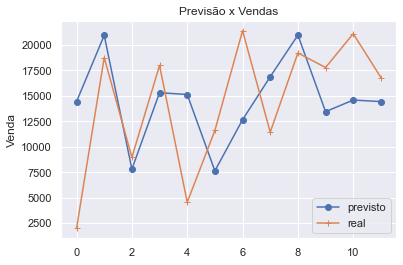

Wall time: 283 ms

Algorítmo: Random Forest
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
RMSE:  6344.428455787983
MSE:  40251772.43061229
MAPE:  81.42902549717239 %
R2 Score:  -283.60992936266825
R2 Ajustado:  -520.7848704982251


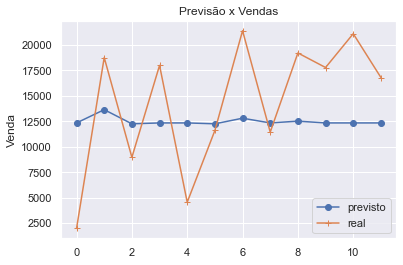

{'criterion': 'mse', 'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 80, 'n_jobs': -1, 'random_state': 0}
Wall time: 4min 21s

Algorítmo: SVM
Parâmetros do modelo: padrão.

RMSE:  6139.183401493434
MSE:  37689572.837172486
MAPE:  80.98230509573364 %
R2 Score:  -1.1617421118000877
R2 Ajustado:  -2.9631938716334942


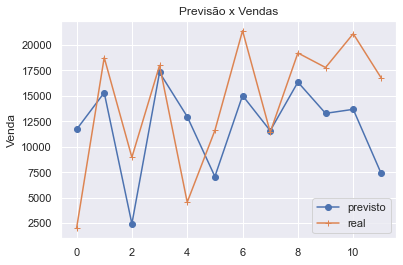

Wall time: 45 s

Algorítmo: SVM
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
RMSE:  6229.282206141301
MSE:  38803956.80374863
MAPE:  84.34737568449387 %
R2 Score:  -1.7273947537664136
R2 Ajustado:  -4.000223715238425


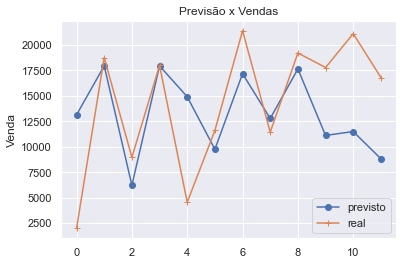

{'C': 6.0, 'epsilon': 0.1, 'kernel': 'linear', 'tol': 0.001}
Wall time: 3min 45s

--------------------------------------------------

Cenário 2: janela de 4 semanas

Algorítmo: Random Forest
Parâmetros do modelo: padrão.

RMSE:  14461.610604379179
MSE:  209138181.27269232
MAPE:  50.85759481212 %
R2 Score:  -1.5912754856166176
R2 Ajustado:  -2.084851768591211


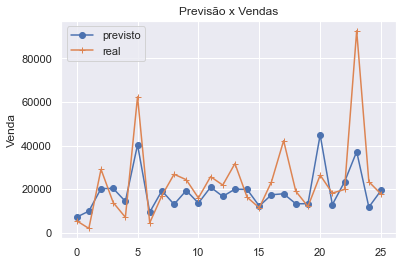

Wall time: 235 ms

Algorítmo: Random Forest
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
RMSE:  14941.055586510687
MSE:  223235142.0392022
MAPE:  52.50056069268344 %
R2 Score:  -2.4416063454869903
R2 Ajustado:  -3.0971504112940362


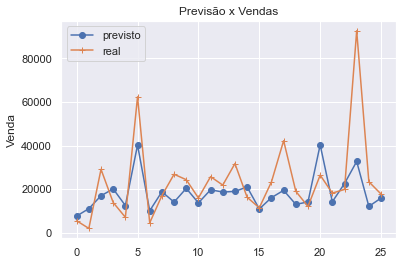

{'criterion': 'mse', 'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 0}
Wall time: 4min 37s

Algorítmo: SVM
Parâmetros do modelo: padrão.

RMSE:  15012.720179550495
MSE:  225381767.18948263
MAPE:  63.35385143842193 %
R2 Score:  -1.0389852552682015
R2 Ajustado:  -1.4273633991288115


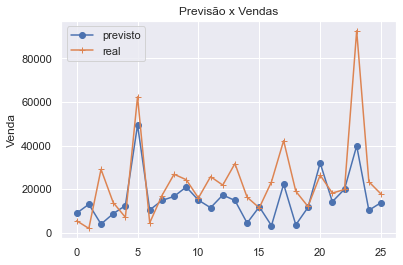

Wall time: 1min 48s

Algorítmo: SVM
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
RMSE:  17889.03989027022
MSE:  320017748.1956792
MAPE:  71.75587952640521 %
R2 Score:  -21.98891951613609
R2 Ajustado:  -26.36776132873344


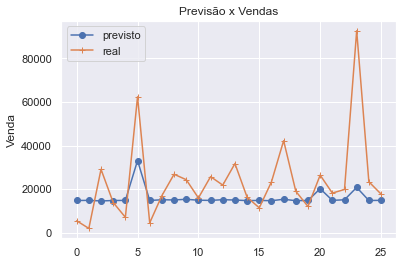

{'C': 6.0, 'epsilon': 0.1, 'kernel': 'poly', 'tol': 0.001}
Wall time: 17min 36s

--------------------------------------------------

Cenário 3: janela de 12 semanas

Algorítmo: Random Forest
Parâmetros do modelo: padrão.

RMSE:  10272.769508186842
MSE:  105529793.36833334
MAPE:  10082.726909147641 %
R2 Score:  -0.14219128048929042
R2 Ajustado:  -1.388218131932153


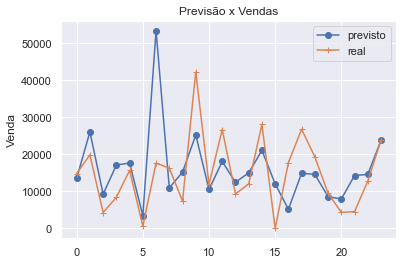

Wall time: 246 ms

Algorítmo: Random Forest
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
RMSE:  9380.44790687858
MSE:  87992802.93366273
MAPE:  8003.573658450593 %
R2 Score:  -0.003480877958258688
R2 Ajustado:  -1.0981872902763588


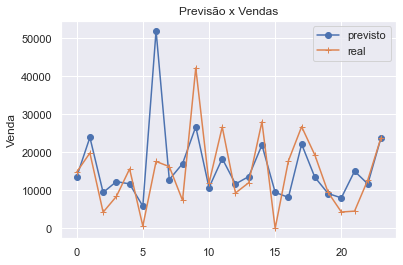

{'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 110, 'n_jobs': -1, 'random_state': 0}
Wall time: 5min 12s

Algorítmo: SVM
Parâmetros do modelo: padrão.

RMSE:  14566.898393059908
MSE:  212194528.7937313
MAPE:  7021.5222114811995 %
R2 Score:  0.0004402651522662504
R2 Ajustado:  -1.0899885364998068


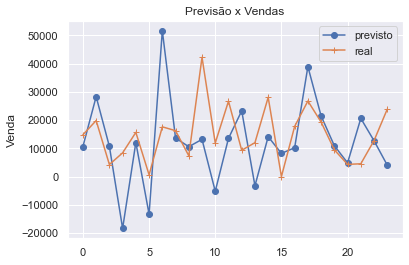

Wall time: 5min 12s

Algorítmo: SVM
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
RMSE:  5908.1461446024
MSE:  34906190.86598021
MAPE:  7630.906575506338 %
R2 Score:  0.01997777015644131
R2 Ajustado:  -1.0491373896728953


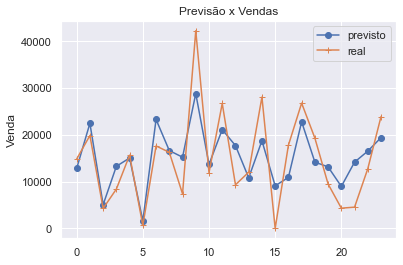

{'C': 1.0, 'epsilon': 0.1, 'kernel': 'linear', 'tol': 0.001}
Wall time: 1h 6min 22s

--------------------------------------------------

Cenário 4: janela de 24 semanas

Algorítmo: Random Forest
Parâmetros do modelo: padrão.

RMSE:  8171.667795749587
MSE:  66776154.564090915
MAPE:  76.04277639402994 %
R2 Score:  -0.09604318401723155
R2 Ajustado:  8.672302288120623


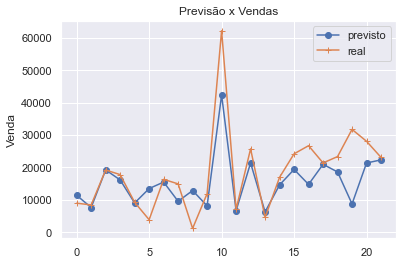

Wall time: 241 ms

Algorítmo: Random Forest
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
RMSE:  8243.90624286915
MSE:  67961990.14121695
MAPE:  80.38684687376285 %
R2 Score:  0.0969403086718178
R2 Ajustado:  7.3214178392972755


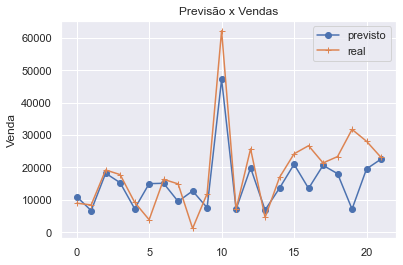

{'criterion': 'mse', 'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 0}
Wall time: 4min 53s

Algorítmo: SVM
Parâmetros do modelo: padrão.

RMSE:  39146.01806121464
MSE:  1532410730.0489428
MAPE:  330.13225196406586 %
R2 Score:  -0.04889082193484273
R2 Ajustado:  8.3422357535439


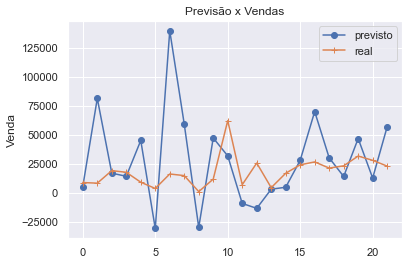

Wall time: 56min 34s

Algorítmo: SVM
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
RMSE:  12881.25320153015
MSE:  165926684.04193074
MAPE:  112.89092237083729 %
R2 Score:  -362.1199876673644
R2 Ajustado:  2542.8399136715507


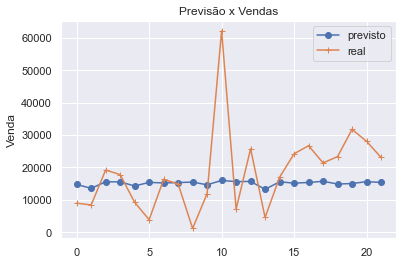

{'C': 16.0, 'epsilon': 0.1, 'kernel': 'poly', 'tol': 0.001}
Wall time: 1h 51min 7s

--------------------------------------------------

Cenário 5: janela de 36 semanas

Algorítmo: Random Forest
Parâmetros do modelo: padrão.

RMSE:  17704.300066706957
MSE:  313442240.852
MAPE:  17326.78812619131 %
R2 Score:  -1.2735579587906196
R2 Ajustado:  3.541035365707163


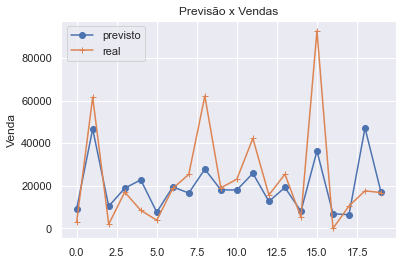

Wall time: 294 ms

Algorítmo: Random Forest
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
RMSE:  15113.466179371972
MSE:  228416859.95502043
MAPE:  12957.894514834075 %
R2 Score:  -0.8348839994868873
R2 Ajustado:  3.050752705308874


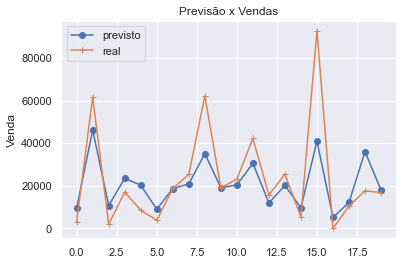

{'criterion': 'mse', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 70, 'n_jobs': -1, 'random_state': 0}
Wall time: 5min 48s

Algorítmo: SVM
Parâmetros do modelo: padrão.

RMSE:  44540.980945571566
MSE:  1983898983.5937696
MAPE:  26982.848993099673 %
R2 Score:  -0.2091253728305409
R2 Ajustado:  2.3513754166929575


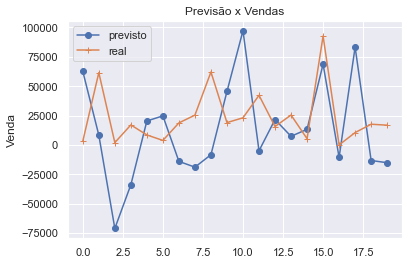

Wall time: 25min

Algorítmo: SVM
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
RMSE:  24808.690755232623
MSE:  615471136.9887645
MAPE:  29809.088191939696 %
R2 Score:  -1281.5984223411028
R2 Ajustado:  1434.4923543812326


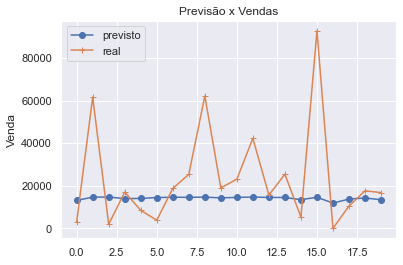

{'C': 16.0, 'epsilon': 0.1, 'kernel': 'poly', 'tol': 0.001}
Wall time: 5h 33min 41s

--------------------------------------------------

Cenário 6: janela de 52 semanas

Algorítmo: Random Forest
Parâmetros do modelo: padrão.

RMSE:  8209.14887861403
MSE:  67390125.31125
MAPE:  43212.80629533585 %
R2 Score:  -3.4505137155356946
R2 Ajustado:  2.8042623171090657


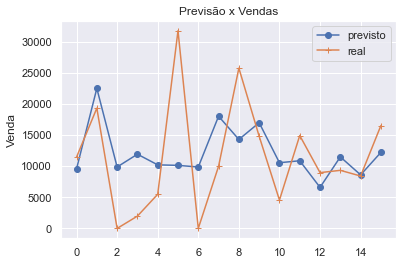

Wall time: 269 ms

Algorítmo: Random Forest
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
RMSE:  7896.978471445279
MSE:  62362268.97847022
MAPE:  38471.4680282622 %
R2 Score:  -3.9272066669551418
R2 Ajustado:  2.9975162163331657


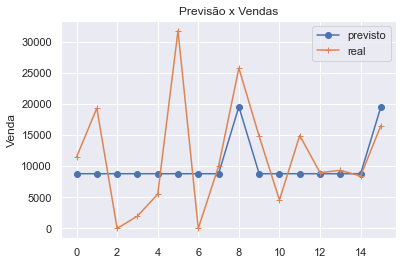

{'criterion': 'mse', 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 1, 'n_jobs': -1, 'random_state': 0}
Wall time: 5min 10s

Algorítmo: SVM
Parâmetros do modelo: padrão.

RMSE:  147549.69309644034
MSE:  21770911932.853737
MAPE:  622881.8929867689 %
R2 Score:  0.02455871053318015
R2 Ajustado:  1.3954491714054675


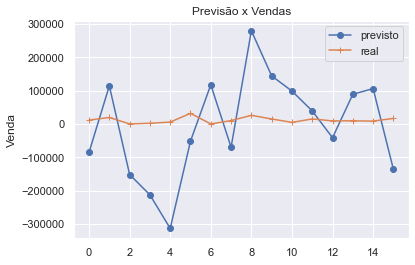

Wall time: 29min 47s

Algorítmo: SVM
Parâmetros do modelo: melhores.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
RMSE:  9081.967953085337
MSE:  82482141.90086909
MAPE:  62312.62685466279 %
R2 Score:  -491.72101928153745
R2 Ajustado:  200.75176457359626


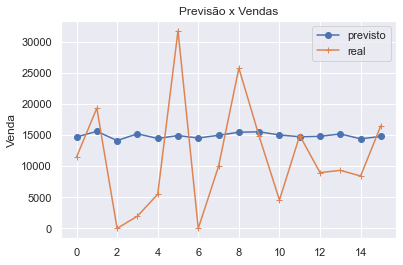

{'C': 16.0, 'epsilon': 0.1, 'kernel': 'poly', 'tol': 0.001}
Wall time: 25.5 s

--------------------------------------------------



In [47]:
# funções geradoras dos conjuntos de dados de cada cenário que iremos analisar
f_gerar_ano_anterior_e_corrente = lambda: monta_dataset_ano_anterior(dataset=df_venda_preparado)
f_gerar_4_semanas               = lambda: monta_dataset_por_janela(dataset=df_venda_historico_agrupado, window=4)
f_gerar_12_semanas              = lambda: monta_dataset_por_janela(dataset=df_venda_historico_agrupado, window=12)
f_gerar_24_semanas              = lambda: monta_dataset_por_janela(dataset=df_venda_historico_agrupado, window=24)
f_gerar_36_semanas              = lambda: monta_dataset_por_janela(dataset=df_venda_historico_agrupado, window=36)
f_gerar_52_semanas              = lambda: monta_dataset_por_janela(dataset=df_venda_historico_agrupado, window=52)

# um iterável ordenado de dicionários, contendo os nomes dos cenários e um lambda para gerar
# o conjunto de dados (evitamos incluir os dados no dicionário para não aumentar o footprint 
# de memória)
cenarios_analise_ml = (
    { 'nome':'ano anterior e corrente', 'f_gerar_dataset': f_gerar_ano_anterior_e_corrente},
    { 'nome':'janela de 4 semanas',     'f_gerar_dataset': f_gerar_4_semanas},
    { 'nome':'janela de 12 semanas',    'f_gerar_dataset': f_gerar_12_semanas},
    { 'nome':'janela de 24 semanas',    'f_gerar_dataset': f_gerar_24_semanas},
    { 'nome':'janela de 36 semanas',    'f_gerar_dataset': f_gerar_36_semanas},
    { 'nome':'janela de 52 semanas',    'f_gerar_dataset': f_gerar_52_semanas}
)

algoritmos_ml = (
    { 'nome': 'Random Forest', 'f_train_predict': train_predict_random_forest},
    { 'nome': 'SVM'          , 'f_train_predict': train_predict_svm}
)

# percorremos os cenários, treinando os algoritmos de IA e fazendo previsões nos dados
# cenários x algoritmos (com e sem otimização de hiper-parâmetros)
for idx, cenario in enumerate(cenarios_analise_ml):
    nome_cenario = cenario['nome']
    f_gerar_dataset = cenario['f_gerar_dataset']
    X_train, X_test, y_train, y_test = f_gerar_dataset() # aqui, chamamos a função lambda para obter os dados do cenário
    
    print(f'Cenário {idx + 1}: {nome_cenario}' + os.linesep)
    
    for alg in algoritmos_ml:
        nome_alg = alg['nome']
        f_train_predict = alg['f_train_predict']
        
        for best_model in (False, True):
            s_best_model = 'melhores' if best_model else 'padrão'
            
            print(f'Algoritmo: {nome_alg}')
            print(f'Parâmetros do modelo: {s_best_model}.' + os.linesep)
            
            %time f_train_predict(X_train, X_test, y_train, y_test, best_model)
            print()
    
    print(('-' * 50) + os.linesep)

---